In [2]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical # type: ignore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [3]:
def load_images_from_subfolders(base_folder, img_size=(64, 64), augment=False):
    images = []
    labels = []

    # Define data augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1,
        horizontal_flip=False,
        fill_mode='nearest'
    )

    for label in os.listdir(base_folder):
        label_folder = os.path.join(base_folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                if filename.endswith('.png') or filename.endswith('.jpg'):
                    img = Image.open(os.path.join(label_folder, filename)).convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img)
                    img_array = np.expand_dims(img_array, 0)  # Expand dimensions to match input shape

                    # Apply data augmentation if augment flag is True
                    if augment:
                        augmented_images = datagen.flow(img_array, batch_size=1)
                        for _ in range(5):  # Generate 5 augmented images for each original image
                            aug_img = next(augmented_images)[0].astype(np.uint8)
                            images.append(aug_img)
                            labels.append(label)
                    else:
                        images.append(img_array[0])
                        labels.append(label)

    return np.array(images), np.array(labels)

base_folder = 'datasets'
img_size = (28, 28) 
images, labels = load_images_from_subfolders(base_folder, img_size, augment=True)

In [4]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
onehot_labels = to_categorical(labels)  # Convert to one-hot encoding

In [6]:
def display_image(image_array):
    plt.imshow(image_array, cmap='gray')
    plt.axis('off')  # Turn off axis labels
    plt.show()

def rgb_to_grayscale(images):
    grayscale_images = np.dot(images[...,:3], [0.299, 0.587, 0.114])
    return grayscale_images

In [7]:
images = images.astype('float32') / 255.0
grayscale_images = rgb_to_grayscale(images)  # Add channel dimensio
grayscale_images = np.expand_dims(grayscale_images, axis=-1)

In [8]:
# Split dataset
x_train, x_test, y_train, y_test = train_test_split(grayscale_images, onehot_labels, test_size=0.2)

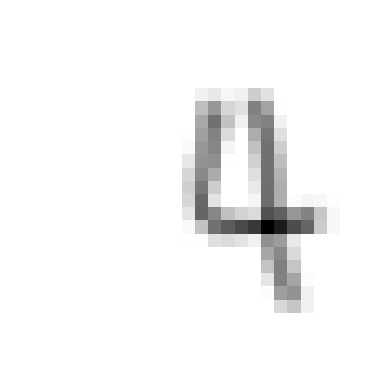

(28, 28, 1)


In [9]:
display_image(x_train[0])
print(x_train[0].shape)

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(units = 19, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

c:\Users\salos\MathPad-Solver\mathsolver\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 19)             │         1,235 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,587 (474.95 KB)

 Trainable params: 121,587 (474.95 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3132 - loss: 2.2473 - val_accuracy: 0.7338 - val_loss: 0.9116
Epoch 2/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7566 - loss: 0.8203 - val_accuracy: 0.8258 - val_loss: 0.5822
Epoch 3/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8427 - loss: 0.5246 - val_accuracy: 0.8782 - val_loss: 0.4183
Epoch 4/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8840 - loss: 0.3890 - val_accuracy: 0.9030 - val_loss: 0.3349
Epoch 5/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9057 - loss: 0.3105 - val_accuracy: 0.9082 - val_loss: 0.3145
Epoch 6/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9225 - loss: 0.2570 - val_accuracy: 0.9212 - val_loss: 0.2724
Epoch 7/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9362 - loss: 0.2141 - val_accuracy: 0.9165 - val_loss: 0.2744
Epoch 8/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9418 - loss: 0.1895 - 

# Save Model

In [13]:
model.save('Augmented_model.h5')

# Load Model

In [43]:
loaded_model = load_model(r'new_model.h5')

In [12]:
def preprocess_image(img_path, target_size=(28, 28)):
    img = Image.open(img_path).convert('L')
    img = img.resize(target_size)
    img_array = np.array(img).astype('float32') / 255.0
    img_array = img_array.reshape((1, target_size[0], target_size[1], 1))
    return img_array

In [11]:
def list_files_in_folder(base_folder):
    for root, dirs, files in os.walk(base_folder):
        for file in files:
            yield os.path.join(root, file)

In [13]:
index_to_label = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add','dec'
       'div', 'eq', 'mul', 'sub', 'x', 'y', 'z']

In [7]:
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    predictions = loaded_model.predict(img_array,verbose=0)
    predicted_class = np.argmax(predictions, axis=1)
    print(index_to_label[predicted_class[0]])

In [ ]:
base_folder = r'C:\Users\salos\MathPad-Solver\test-digit'
for file_path in list_files_in_folder(base_folder):
    img_array = preprocess_image(file_path)
    predictions = loaded_model.predict(img_array,verbose=0)
    predicted_class = np.argmax(predictions, axis=1)
    print(index_to_label[predicted_class[0]])

In [9]:
img_array = predict_image(r'C:\Users\salos\MathPad-Solver\recognition\custom_model\datasets\sub\xrCP3RgB.png')


sub
